### Uncomment and run the following block of code to get the simulation library

In [28]:
#if importlib.util.find_spec('pyflamegpu') is None:
#    import sys
#    !{sys.executable} -m pip install -I https://github.com/FLAMEGPU/FLAMEGPU2/releases/download/v2.0.0-rc/pyflamegpu-2.0.0rc0+cuda112-cp39-cp39-linux_x86_64.whl # type: ignore



In [29]:
import importlib.util
#if importlib.util.find_spec('pyflamegpu') is None:
#    import sys
#    !{sys.executable} -m pip install -I https://github.com/FLAMEGPU/FLAMEGPU2/releases/download/v2.0.0-rc/pyflamegpu-2.0.0rc0+cuda112-cp39-cp39-linux_x86_64.whl # type: ignore

import pyflamegpu as fg
import sys, random, math
import matplotlib.pyplot as plt


In [30]:

#Agent state variables
AGENT_STATUS_UNOCCUPIED = 0
AGENT_STATUS_OCCUPIED =1
AGENT_STATUS_MOVEMENT_REQUESTED= 2
AGENT_STATUS_MOVEMENT_UNRESOLVED =3

# Growback variables
ENV_SUGAR_GROWBACK_RATE =1
ENV_SUGAR_MAX_CAPACITY =10
MIN_HOTSPOT_DISTANCE =20

MIN_INIT_AGENT_SUAGR_WEALTH =5
MAX_INIT_AGENT_SUAGR_WEALTH =25

MIN_INIT_METABOLISM =1
MAX_INIT_METABOLISM =4
PROBABILITY_OF_OCCUPATION =0.17


# Visualisation mode (0=occupied/move status, 1=occupied/sugar/level)

# Counter for number of iterations required to resolve conflicting movements
exit_condition_iterations = 0
occupied = 0


step_unresolved_count = [0,0,0,0,0,0,0,0,0]
mean_unresolved_count = [0,0,0,0,0,0,0,0,0]

gridWidth = 100

## Agent Functions must be Declared in C++ 

In [31]:
metabolise_and_growback = r"""
FLAMEGPU_AGENT_FUNCTION(metabolise_and_growback, flamegpu::MessageNone, flamegpu::MessageNone) {
    const int AGENT_STATUS_UNOCCUPIED = 0;
    const int AGENT_STATUS_OCCUPIED =1;
    const int AGENT_STATUS_MOVEMENT_REQUESTED= 2;
    const int AGENT_STATUS_MOVEMENT_UNRESOLVED =3;
    const int ENV_SUGAR_GROWBACK_RATE =1;
    const int ENV_SUGAR_MAX_CAPACITY =4;
    const int MIN_HOTSPOT_DISTANCE =20;
    int sugar_level = FLAMEGPU->getVariable<int>("sugar_level");
    int env_sugar_level = FLAMEGPU->getVariable<int>("env_sugar_level");
    int env_max_sugar_level = FLAMEGPU->getVariable<int>("env_max_sugar_level");
    int status = FLAMEGPU->getVariable<int>("status");
    // metabolise if occupied
    if (status == AGENT_STATUS_OCCUPIED || status == AGENT_STATUS_MOVEMENT_UNRESOLVED) {
        // store any sugar present in the cell
        if (env_sugar_level > 0) {
            sugar_level += env_sugar_level;
            // Occupied cells are marked as -1 sugar.
            env_sugar_level = -1;
        }

        // metabolise
        sugar_level -= FLAMEGPU->getVariable<int>("metabolism");

        // check if agent dies
        if (sugar_level == 0) {
            status = AGENT_STATUS_UNOCCUPIED;
            FLAMEGPU->setVariable<int>("agent_id", -1);
            env_sugar_level = 0;
            FLAMEGPU->setVariable<int>("metabolism", 0);
        }
    }

    // growback if unoccupied
    if (status == AGENT_STATUS_UNOCCUPIED) {
        env_sugar_level += ENV_SUGAR_GROWBACK_RATE;
        if (env_sugar_level > env_max_sugar_level) {
            env_sugar_level = env_max_sugar_level;
        }
    }

    // set all active agents to unresolved as they may now want to move
    if (status == AGENT_STATUS_OCCUPIED) {
        status = AGENT_STATUS_MOVEMENT_UNRESOLVED;
    }
    FLAMEGPU->setVariable<int>("sugar_level", sugar_level);
    FLAMEGPU->setVariable<int>("env_sugar_level", env_sugar_level);
    FLAMEGPU->setVariable<int>("status", status);

    return flamegpu::ALIVE;
}
"""

In [32]:
output_cell_status = r"""
FLAMEGPU_AGENT_FUNCTION(output_cell_status, flamegpu::MessageNone, flamegpu::MessageArray2D) {
    unsigned int agent_x = FLAMEGPU->getVariable<unsigned int, 2>("pos", 0);
    unsigned int agent_y = FLAMEGPU->getVariable<unsigned int, 2>("pos", 1);
    FLAMEGPU->message_out.setVariable("location_id", FLAMEGPU->getID());
    FLAMEGPU->message_out.setVariable("status", FLAMEGPU->getVariable<int>("status"));
    FLAMEGPU->message_out.setVariable("env_sugar_level", FLAMEGPU->getVariable<int>("env_sugar_level"));
    FLAMEGPU->message_out.setIndex(agent_x, agent_y);
    return flamegpu::ALIVE;
}
"""

In [33]:
movement_request = r"""
FLAMEGPU_AGENT_FUNCTION(movement_request, flamegpu::MessageArray2D, flamegpu::MessageArray2D) {
    const int AGENT_STATUS_UNOCCUPIED = 0;
    const int AGENT_STATUS_OCCUPIED =1;
    const int AGENT_STATUS_MOVEMENT_REQUESTED= 2;
    const int AGENT_STATUS_MOVEMENT_UNRESOLVED =3;
    int best_sugar_level = -1;
    float best_sugar_random = -1;
    flamegpu::id_t best_location_id = flamegpu::ID_NOT_SET;

    // if occupied then look for empty cells {
    // find the best location to move to (ensure we don't just pick first cell with max value)
    int status = FLAMEGPU->getVariable<int>("status");

    unsigned int agent_x = FLAMEGPU->getVariable<unsigned int, 2>("pos", 0);
    unsigned int agent_y = FLAMEGPU->getVariable<unsigned int, 2>("pos", 1);

    // if occupied then look for empty cells
    if (status == AGENT_STATUS_MOVEMENT_UNRESOLVED) {
        for (auto current_message : FLAMEGPU->message_in.wrap(agent_x, agent_y)) {
            // if location is unoccupied then check for empty locations
            if (current_message.getVariable<int>("status") == AGENT_STATUS_UNOCCUPIED) {
                // if the sugar level at current location is better than currently stored then update
                int message_env_sugar_level = current_message.getVariable<int>("env_sugar_level");
                float message_priority = FLAMEGPU->random.uniform<float>();
                if ((message_env_sugar_level > best_sugar_level) ||
                    (message_env_sugar_level == best_sugar_level && message_priority > best_sugar_random)) {
                    best_sugar_level = message_env_sugar_level;
                    best_sugar_random = message_priority;
                    best_location_id = current_message.getVariable<flamegpu::id_t>("location_id");
                }
            }
        }

        // if the agent has found a better location to move to then update its state
        // if there is a better location to move to then state indicates a movement request
        status = best_location_id != flamegpu::ID_NOT_SET ? AGENT_STATUS_MOVEMENT_REQUESTED : AGENT_STATUS_OCCUPIED;
        FLAMEGPU->setVariable<int>("status", status);
    }

    // add a movement request
    FLAMEGPU->message_out.setVariable<int>("agent_id", FLAMEGPU->getVariable<int>("agent_id"));
    FLAMEGPU->message_out.setVariable<flamegpu::id_t>("location_id", best_location_id);
    FLAMEGPU->message_out.setVariable<int>("sugar_level", FLAMEGPU->getVariable<int>("sugar_level"));
    FLAMEGPU->message_out.setVariable<int>("metabolism", FLAMEGPU->getVariable<int>("metabolism"));
    FLAMEGPU->message_out.setIndex(agent_x, agent_y);

    return flamegpu::ALIVE;
}
"""

In [34]:
movement_response = r"""
FLAMEGPU_AGENT_FUNCTION(movement_response, flamegpu::MessageArray2D, flamegpu::MessageArray2D) {
    const int AGENT_STATUS_UNOCCUPIED = 0;
    const int AGENT_STATUS_OCCUPIED =1;
    const int AGENT_STATUS_MOVEMENT_REQUESTED= 2;
    const int AGENT_STATUS_MOVEMENT_UNRESOLVED =3;
    int best_request_id = -1;
    float best_request_priority = -1;
    int best_request_sugar_level = -1;
    int best_request_metabolism = -1;

    int status = FLAMEGPU->getVariable<int>("status");
    const flamegpu::id_t location_id = FLAMEGPU->getID();
    const unsigned int agent_x = FLAMEGPU->getVariable<unsigned int, 2>("pos", 0);
    const unsigned int agent_y = FLAMEGPU->getVariable<unsigned int, 2>("pos", 1);

    for (auto current_message : FLAMEGPU->message_in.wrap(agent_x, agent_y)) {
        // if the location is unoccupied then check for agents requesting to move here
        if (status == AGENT_STATUS_UNOCCUPIED) {
            // check if request is to move to this location
            if (current_message.getVariable<flamegpu::id_t>("location_id") == location_id) {
                // check the priority and maintain the best ranked agent
                float message_priority = FLAMEGPU->random.uniform<float>();
                if (message_priority > best_request_priority) {
                    best_request_id = current_message.getVariable<int>("agent_id");
                    best_request_priority = message_priority;
                }
            }
        }
    }

    // if the location is unoccupied and an agent wants to move here then do so and send a response
    if ((status == AGENT_STATUS_UNOCCUPIED) && (best_request_id >= 0)) {
        FLAMEGPU->setVariable<int>("status", AGENT_STATUS_OCCUPIED);
        // move the agent to here and consume the cell's sugar
        best_request_sugar_level += FLAMEGPU->getVariable<int>("env_sugar_level");
        FLAMEGPU->setVariable<int>("agent_id", best_request_id);
        FLAMEGPU->setVariable<int>("sugar_level", best_request_sugar_level);
        FLAMEGPU->setVariable<int>("metabolism", best_request_metabolism);
        FLAMEGPU->setVariable<int>("env_sugar_level", -1);
    }

    // add a movement response
    FLAMEGPU->message_out.setVariable<int>("agent_id", best_request_id);
    FLAMEGPU->message_out.setIndex(agent_x, agent_y);

    return flamegpu::ALIVE;
}
"""

In [35]:
movement_transaction = r"""
FLAMEGPU_AGENT_FUNCTION(movement_transaction, flamegpu::MessageArray2D, flamegpu::MessageNone) {
    const int AGENT_STATUS_UNOCCUPIED = 0;
    const int AGENT_STATUS_OCCUPIED =1;
    const int AGENT_STATUS_MOVEMENT_REQUESTED= 2;
    const int AGENT_STATUS_MOVEMENT_UNRESOLVED =3;
    int status = FLAMEGPU->getVariable<int>("status");
    int agent_id = FLAMEGPU->getVariable<int>("agent_id");
    unsigned int agent_x = FLAMEGPU->getVariable<unsigned int, 2>("pos", 0);
    unsigned int agent_y = FLAMEGPU->getVariable<unsigned int, 2>("pos", 1);

    for (auto current_message : FLAMEGPU->message_in.wrap(agent_x, agent_y)) {
        // if location contains an agent wanting to move then look for responses allowing relocation
        if (status == AGENT_STATUS_MOVEMENT_REQUESTED) {  // if the movement response request came from this location
            if (current_message.getVariable<int>("agent_id") == agent_id) {
                // remove the agent and reset agent specific variables as it has now moved
                status = AGENT_STATUS_UNOCCUPIED;
                FLAMEGPU->setVariable<int>("agent_id", -1);
                FLAMEGPU->setVariable<int>("sugar_level", 0);
                FLAMEGPU->setVariable<int>("metabolism", 0);
                FLAMEGPU->setVariable<int>("env_sugar_level", 0);
            }
        }
    }

    // if request has not been responded to then agent is unresolved
    if (status == AGENT_STATUS_MOVEMENT_REQUESTED) {
        status = AGENT_STATUS_MOVEMENT_UNRESOLVED;
    }

    FLAMEGPU->setVariable<int>("status", status);

    return flamegpu::ALIVE;
}

"""

In [36]:
global occupied


In [37]:
## Host function for tracking sim state

In [38]:
# Define a host function called init_fn
class MovementExitCondition(fg.HostCondition):
  def run(self, FLAMEGPU):
    # Behaviour goes here
    global exit_condition_iterations
    global step_unresolved_count
    #global occupied
    global occupied

    # Increment the exit_condition_iterations
    exit_condition_iterations += 1

    # Max iterations 9
    if exit_condition_iterations < 9:
        #unresolved = 0
        # Agent movements still unresolved
        unresolved =  FLAMEGPU.agent("agent").countInt("status", AGENT_STATUS_MOVEMENT_UNRESOLVED)
        step_unresolved_count[exit_condition_iterations] = unresolved
        if unresolved:
            return fg.CONTINUE # Continue (flamegpu::CONTINUE)

    # Save the number of occupied cells after exit condition
    occupied = FLAMEGPU.agent("agent").countInt("status", AGENT_STATUS_OCCUPIED)

    # Reset exit_condition_iterations
    exit_condition_iterations = 0

    return fg.EXIT  # Exit (flamegpu::EXIT)


In [39]:
def define_agents(model,name = "agent"):
  agent = model.newAgent(name)
  agent.newVariableArrayInt("pos",2)
  agent.newVariableInt("agent_id")
  agent.newVariableInt("status")
  #agent specific variables
  agent.newVariableInt("sugar_level")
  agent.newVariableInt("metabolism")
  #environment specific var
  agent.newVariableInt("env_sugar_level")
  agent.newVariableInt("env_max_sugar_level")
  #Redundant seperate floating point position vars for vis
  agent.newVariableFloat("x")
  agent.newVariableFloat("y")
      # Create a function to output cell status

  return agent

In [40]:
def define_submodel(model):
    # Define sub model for conflict resolution
    submodel = fg.ModelDescription("movement_conflict_resolution_model")

    # Messages
    agent = submodel.newAgent("agent")
    agent.newVariableArrayInt("pos",2)
    agent.newVariableInt("agent_id")
    agent.newVariableInt("status")
    #agent specific variables
    agent.newVariableInt("sugar_level")
    agent.newVariableInt("metabolism")
    #environment specific var
    agent.newVariableInt("env_sugar_level")
    agent.newVariableInt("env_max_sugar_level")
    #Redundant seperate floating point position vars for vis
    agent.newVariableFloat("x")
    agent.newVariableFloat("y")
    # cell_status message
    message = submodel.newMessageArray2D("cell_status")
    message.newVariableID("location_id")
    message.newVariableInt("status")
    message.newVariableInt("env_sugar_level")
    message.setDimensions(gridWidth, gridWidth)

    # movement_request message
    message = submodel.newMessageArray2D("movement_request")
    message.newVariableInt("agent_id")
    message.newVariableID("location_id")
    message.newVariableInt("sugar_level")
    message.newVariableInt("metabolism")
    message.setDimensions(gridWidth, gridWidth)

    # movement_response message
    message = submodel.newMessageArray2D("movement_response")
    message.newVariableID("location_id")
    message.newVariableInt("agent_id")
    message.setDimensions(gridWidth, gridWidth)

    # Agents

    # Create a core agent
    #agent = define_agents(submodel, name="agent")

   
    # Create a function to output cell status

    fn_output_cell_status = agent.newRTCFunction("output_cell_status", output_cell_status)
    fn_output_cell_status.setMessageOutput("cell_status")

    # Create a function to request movement
    fn_movement_request = agent.newRTCFunction("movement_request", movement_request)
    fn_movement_request.setMessageInput("cell_status")
    fn_movement_request.setMessageOutput("movement_request")

    # Create a function to respond to movement
    fn_movement_response = agent.newRTCFunction("movement_response", movement_response)
    fn_movement_response.setMessageInput("movement_request")
    fn_movement_response.setMessageOutput("movement_response")

    # Create a function to process movement transactions
    fn_movement_transaction = agent.newRTCFunction("movement_transaction", movement_transaction)
    fn_movement_transaction.setMessageInput("movement_response")
    # Define layers

    # Layer #1
    layer = submodel.newLayer()
    layer.addAgentFunction("agent", "output_cell_status")

    # Layer #2
    layer = submodel.newLayer()
    layer.addAgentFunction("agent", "movement_request")

    # Layer #3
    layer = submodel.newLayer()
    layer.addAgentFunction("agent","movement_response")

    # Layer #4
    layer = submodel.newLayer()
    layer.addAgentFunction("agent","movement_transaction")

    # Add exit condition
    submodel.addExitCondition(MovementExitCondition())
 
    #movement_sub = model.newSubModel("movement_conflict_resolution_model", submodel)

    #movement_sub.bindAgent("agent", "agent", True, True)
    return submodel

In [41]:
model = fg.ModelDescription("Overmodel")

# Define agents

# Per cell agent
agent = define_agents(model)

# Functions
agent.newRTCFunction("metabolise_and_growback", metabolise_and_growback)

# Submodels
submodel = define_submodel(model)
# Movement submodel
movement_sub = model.newSubModel("movement_conflict_resolution_model", submodel)

# Bind agent


# Globals

# Environment
#env = model.Environment()

# Control flow

# Layer #1
layer = model.newLayer()
layer.addAgentFunction("agent", "metabolise_and_growback")

# Layer #2
layer = model.newLayer()
layer.addSubModel(movement_sub)



In [42]:
import math

def hotspot_distance_check(sugar_hotspots, hs, gridWidth):
    is_valid = True
    for h in sugar_hotspots:
        # Calculate the distance between spots
        dx = abs(hs[0] - h[0])
        dy = abs(hs[1] - h[1])
        # If distance in a dimension is greater than half grid width then points are closer via wrapping
        if dx > (gridWidth >> 1):
            dx = gridWidth - dx
        if dy > (gridWidth >> 1):
            dy = gridWidth - dy

        if math.sqrt((dx ** 2 + dy ** 2)) < MIN_HOTSPOT_DISTANCE:
            is_valid = False
    return is_valid


In [43]:
import random

# Set random seed
rng = random.Random()

# Pre-initialize sugar hotspots
sugar_hotspots = []

# Create uniform distributions for width and height
width_dist = random.uniform(0, gridWidth - 1)
height_dist = random.uniform(0, gridWidth - 1)

# Calculate number of hotspots
num_hotspots = int((2 * gridWidth * gridWidth) / (49 * 49))

# Create hotspots
for h in range(num_hotspots):
    # Create random position for new hotspot
    hs = [random.uniform(0, gridWidth - 1), random.uniform(0, gridWidth - 1)]

    # Recursively ensure that the a random position is not within an euclidean distance of 10
    attempts = 0
    while not hotspot_distance_check(sugar_hotspots, hs, gridWidth):
        hs = [random.uniform(0, gridWidth - 1), random.uniform(0, gridWidth - 1)]
        attempts += 1

        # Give up if no position found after 100 attempts
        if attempts == 100:
            print("Warning: Maximum attempts reached creating unique location for sugar hotspot.")
            break

    # Add hotspot after it has passed the distance checks
    sugar_hotspots.append(hs)


In [44]:
pOccupation = 0.1

In [45]:
class population_tracker(fg.HostFunction):
    def __init__(self):
        super().__init__();  # Mandatory if we are defining __init__ ourselves
        # Local, so value is maintained between calls to calculate_convergence::run
        self.alive = []
        self.dead = []
    def run(self, FLAMEGPU):
        # Reduce force and overlap
        self.alive.append(FLAMEGPU.agent("agent").countInt("status", AGENT_STATUS_OCCUPIED))
        print(FLAMEGPU.agent("agent").countInt("status", AGENT_STATUS_OCCUPIED))
        #self.prey_count.append(FLAMEGPU.agent("prey").count())

    def plot(self):
        plt.figure(figsize=(16,10))
        plt.rcParams.update({'font.size': 18})
        plt.xlabel("Step")
        plt.ylabel("Population")
        plt.plot(range(0, len(self.alive)), self.alive, 'r', label="Agents alive")
        #plt.plot(range(0, len(self.prey_count)), self.prey_count, 'b', label="Prey")
        #plt.plot(range(0, len(self.grass_count)), self.grass_count, 'g', label="Grass")
        plt.legend()
        plt.show()

    def reset(self):
        self.alive = []
        self.dead = []

In [46]:
pop_tracker = population_tracker()

model.addStepFunction(pop_tracker)


In [47]:
pop_tracker.alive

[]

In [48]:
cudaSimulation = fg.CUDASimulation(model)
#random.seed(cudaSimulation.SimulationConfig().random_seed)


In [49]:
import numpy as np
# Define variables

# Number of cells
CELL_COUNT = gridWidth * gridWidth

# Normal distribution
normal = np.random.uniform(0, 1)

# Agent sugar distribution
#agent_sugar_dist = fg.random.uniformInt(MIN_INIT_AGENT_SUAGR_WEALTH, MAX_INIT_AGENT_SUAGR_WEALTH)
agent_sugar_dist = np.random.uniform(MIN_INIT_AGENT_SUAGR_WEALTH, MAX_INIT_AGENT_SUAGR_WEALTH)
# Agent metabolism distribution
agent_metabolism_dist = np.random.uniform(MIN_INIT_METABOLISM, MAX_INIT_METABOLISM)

# Agent index
i = 0

# Agent ID
agent_id = 0

# Initialize population
init_pop = fg.AgentVector(model.Agent("agent"), CELL_COUNT)

# Loop over cells
for x in range(gridWidth):
    for y in range(gridWidth):
        # Get agent instance
        #print(i)
        instance = init_pop[i]

        # Set position
        instance.setVariableArrayInt("pos", (x, y))

        # 10% chance of cell holding an agent
        if np.random.uniform(0, 1) < pOccupation:

            # Set agent ID
            instance.setVariableInt("agent_id", i)

            # Set agent status
            instance.setVariableInt("status", AGENT_STATUS_OCCUPIED)

            # Set agent sugar level
            instance.setVariableInt("sugar_level", int(random.uniform(MIN_INIT_AGENT_SUAGR_WEALTH, MAX_INIT_AGENT_SUAGR_WEALTH)))

            # Set agent metabolism
            instance.setVariableInt("metabolism",  int(random.uniform(MIN_INIT_METABOLISM, MAX_INIT_METABOLISM)))

        else:

            # Set agent ID
            instance.setVariableInt("agent_id", -1)

            # Set agent status
            instance.setVariableInt("status", AGENT_STATUS_UNOCCUPIED)

            # Set agent sugar level
            instance.setVariableInt("sugar_level", 0)

            # Set agent metabolism
            instance.setVariableInt("metabolism", 0)

        # Environment specific var
        env_sugar_lvl = 0

        # Hotspot core size
        hotspot_core_size = 5

        # Loop over hotspots
        for hs in sugar_hotspots:

            # Get hotspot x and y
            hs_x = int(hs[0])
            hs_y = int(hs[1])

            # Distance to hotspot
            hs_dist = math.sqrt(math.pow(hs_x - x, 2) + math.pow(hs_y - y, 2))

            # Four bands of sugar with increasing radius of 5
            env_sugar_lvl += 4 - min(4, int(math.floor(hs_dist / hotspot_core_size)))

        # Set environment max sugar level
        env_sugar_lvl = min(env_sugar_lvl, ENV_SUGAR_MAX_CAPACITY)


        # Set environment sugar level
        instance.setVariableInt("env_max_sugar_level", env_sugar_lvl)
        instance.setVariableInt("env_sugar_level", env_sugar_lvl)
        instance.setVariableFloat("x",x)
        instance.setVariableFloat("y",y)
        i+= 1

# Set population data
cudaSimulation.setPopulationData(init_pop)


In [50]:
VIS_SIMULATION_SPEED = 1
VIS_MODE =0
visualisation = cudaSimulation.getVisualisation()

# Set simulation speed
visualisation.setSimulationSpeed(VIS_SIMULATION_SPEED)

# Set initial camera location
visualisation.setInitialCameraLocation(gridWidth / 2.0, gridWidth / 2.0, 225.0)

# Set initial camera target
visualisation.setInitialCameraTarget(gridWidth / 2.0, gridWidth / 2.0, 0.0)

# Set camera speed
visualisation.setCameraSpeed(0.001 * gridWidth)

# Set view clips
visualisation.setViewClips(0.1, 5000)

# Set clear color
visualisation.setClearColor(1.0, 1.0, 1.0)

# Set FPS color
visualisation.setFPSColor(0.0, 0.0, 0.0)

# Set start paused
#visualisation.setBeginPaused(True)

# Add agent
agt = visualisation.addAgent("agent")

# Set model
agt.setModel(fg.CUBE)

# Set model scale
agt.setModelScale(1.0)

# If VIS_MODE == 0
if VIS_MODE == 0:

    # Create discrete color
    cell_colors = fg.iDiscreteColor("status", fg.Color("#666"))

    # Set cell colors
    cell_colors[AGENT_STATUS_UNOCCUPIED] = fg.RED
    cell_colors[AGENT_STATUS_OCCUPIED] = fg.GREEN
    cell_colors[AGENT_STATUS_MOVEMENT_REQUESTED] = fg.BLUE
    cell_colors[AGENT_STATUS_MOVEMENT_UNRESOLVED] = fg.WHITE

    # Set agent color
    agt.setColor(cell_colors)



## Uncomment to enable Vizualisation
(Not Working properly)

In [51]:
visualisation.join()
visualisation.activate()

cudaSimulation.simulate()






0


In [52]:
#cudaSimulation.simulate()

In [53]:
#print(captured_stderr)
#step_time = cudaSimulation.getElapsedTimeStep(0)
#occupied

## Benchmark Model

If model is properly functional, alive population over time must chage. In the current state of the model, the population stays constant for some reason, independant of other variables or factors. This indicates something is not functioning correctly, most likely to do with agent interactions or death

In [54]:
sum_pop_count = 0
sum_step_time = 0
pop_array = []
step_array = []
steps = range(1,100,1)
for i in steps:
    #occupied = 0  # reset the counter used in the exit condition
    cudaSimulation.step()
    #print(occupied)
    step_pop_count = occupied
    step_time = cudaSimulation.getElapsedTimeStep(cudaSimulation.step())
    
    # write step csv
    #csv_step.write(f"{repetition},{gridWidth},{popSize},{pOccupation},{i},{step_time},{step_pop_count}\n")
    
    # update average
    sum_pop_count += step_pop_count
    sum_step_time += step_time
    pop_array.append(step_pop_count)
    step_array.append(step_time)
# log total simulation time
#averageStepTime = sum_step_time / steps
#averagePopCount = sum_pop_count / steps


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


Text(0.5, 1.0, 'Change in population over time')

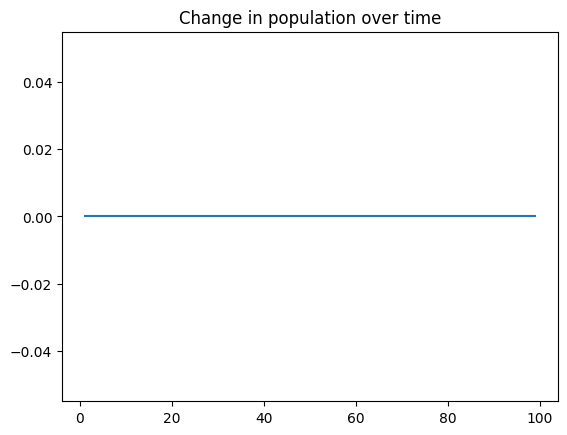

In [56]:
plt.plot(steps, pop_array)
plt.title("Change in population over time")